--------------------Parametros utilizados:--------------------
T:  24.0
Max Estoque:  60
Min Estoque:  1
Qtd inicial estoque:  5
Preço da unid:  50
Custo por unidade 10
Lucro Total: -1238.9570244728166 = -118.86%
Lucro por unidade de tempo: -51.62320935303402

Horários de chegada dos clientes: [0.008289137224221399, 0.17257191929393448, 0.24875394528600284, 0.3590153061891967, 0.4268037612225204, 0.45413910135731544, 0.5557417946595743, 0.5788588802766302, 0.7653589795665456, 0.7767010414379585, 1.0650226692890432, 1.0700248472964462, 1.1446973779612768, 1.1849651926840228, 1.2425368979707363, 1.2569313395384791, 1.3412594716257786, 2.0337449211844607, 2.155335963611845, 2.26373199124653, 2.395839164922162, 2.4911810929285165, 2.6548196258163053, 2.72796772156478, 2.728386351973058, 3.5515625263965553, 3.8967654622385615, 4.144568036451829, 4.312885646587517, 4.6305559618949825, 4.852155336647409, 5.013528495900808, 5.128929425001947, 5.131105084164863, 5.135951864311949, 5.17422795844

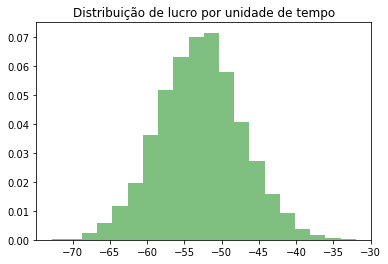


Lucro máximo por unidade de tempo: 21.373329366857906
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 24.0
maxEstoque = 60 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 5 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 10

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 30
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.2
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  24.0
Max Estoque:  45
Min Estoque:  1
Qtd inicial estoque:  2
Preço da unid:  50
Custo por unidade 10
Lucro Total: -129.31940445213831 = -8.54%
Lucro por unidade de tempo: -5.3883085188390965

Horários de chegada dos clientes: [0.10560073369095158, 0.11158230903358637, 0.1574111853335458, 0.18800763030689926, 0.2577771833720691, 0.3513140747744916, 0.3565271989051489, 0.6178185826528886, 0.6783208756658577, 0.8420149750755637, 0.865683937909557, 0.9339769563143724, 1.048928400907388, 1.1380578186761507, 1.3361805817649048, 1.7214939305912944, 2.019689007092658, 2.2140258190359465, 2.230664420454871, 2.2407687128522693, 2.252090949625561, 2.446473326445686, 2.4578228253430416, 2.4644685978635374, 2.528938113644115, 2.547213728079182, 2.568874828844393, 2.621871298855204, 2.7410835686818653, 2.8395597994811888, 2.937782449325062, 3.0818895318797406, 3.1832933517374706, 3.3188793833558123, 3.4046466332236816, 3.47361135820

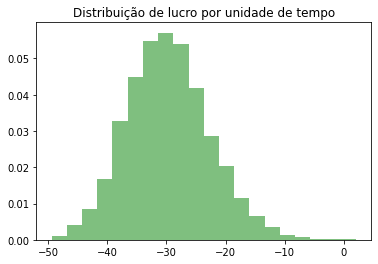


Lucro máximo por unidade de tempo: 20.159772987540137
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 24.0
maxEstoque = 45 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 2 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 10

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 30
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.2
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  24.0
Max Estoque:  30
Min Estoque:  1
Qtd inicial estoque:  2
Preço da unid:  50
Custo por unidade 10
Lucro Total: 123.3987453980236 = 10.58%
Lucro por unidade de tempo: 5.141614391584317

Horários de chegada dos clientes: [0.0015800385273761386, 0.025346980961168275, 0.13656107002852264, 0.23970477160403247, 0.27262933604310896, 0.5338824192786217, 0.6099220209826575, 0.6345085528958367, 0.6900385453343015, 0.7015598401543375, 0.7223973599047943, 1.1330807069183706, 1.1473939112244906, 1.1859126908651918, 1.4254936458555092, 1.7859176246397528, 1.8910976639813395, 1.9968261234325193, 2.0207753243636057, 2.1796682388892936, 2.189407255934126, 2.204559963564343, 2.425697073879873, 2.4530319122834836, 2.505033855478307, 2.5490029090270783, 2.8837147243429446, 2.954554323067565, 2.9940056657196252, 3.6238447816720805, 3.732789988282215, 4.0336578424865515, 4.055960892031049, 4.311138346999443, 4.860282220000637, 4.91818274

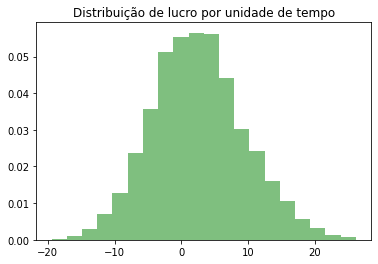


Lucro máximo por unidade de tempo: 19.84627176861101
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 24.0
maxEstoque = 30 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 2 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 10

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 30
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.2
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  24.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  2
Preço da unid:  50
Custo por unidade 10
Lucro Total: 311.1940659163277 = 29.12%
Lucro por unidade de tempo: 12.96641941318032

Horários de chegada dos clientes: [0.17829630824652085, 0.37479715381554496, 0.5673184334300116, 0.588534139016428, 0.6125491534490499, 0.6381079236920673, 0.7723931221646276, 0.7940426258729064, 1.2258041974363079, 1.3466059613365184, 1.4090080107908842, 1.6854618901277012, 1.9214914717101315, 1.9814302945463036, 2.3523661775655067, 2.421695943363492, 2.4711853843360267, 2.9008418439194705, 3.9806029602418667, 4.209800882683738, 4.559917987636085, 4.76413010477399, 4.822112541997227, 4.8331386612807705, 4.8551937368900635, 4.861517818468679, 5.0633243713795535, 5.205299240994039, 5.223351477282128, 5.274241680174888, 5.29270953592573, 5.4299269733508755, 5.753771576353496, 5.8717689696464435, 5.9963659901363755, 6.187415618227469, 6.

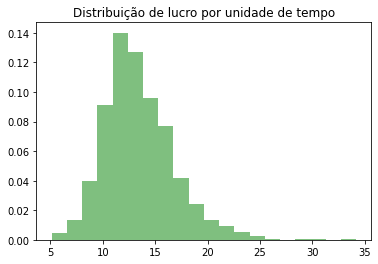

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 24.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 2 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 10

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 30
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.2
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  24.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  50
Custo por unidade 7
Lucro Total: 525.849643449666 = 46.64%
Lucro por unidade de tempo: 21.91040181040275

Horários de chegada dos clientes: [0.03713888164536499, 0.07030315266269059, 0.1972148254207351, 0.24216157895870158, 0.2438181981489225, 0.29006880882367014, 0.4406889067016509, 0.48911710994528446, 0.5743101310292595, 0.7479293121950724, 0.7489697719918396, 0.9005380409388106, 0.9460732158406326, 1.3007001709308559, 1.4581032721343097, 2.2464990975063848, 2.2626954021668966, 2.291003887518019, 2.4296384870475563, 2.4567919003383105, 2.527968594765979, 2.6256719451106614, 2.6766487606946727, 2.711297182380562, 2.7232183563024304, 2.8526357988051676, 2.92130934993382, 3.566727544927129, 3.8110463225949673, 4.18221942017718, 4.4432812977891, 4.506953990842289, 4.9386537969089535, 5.085143026176683, 5.150833801449245, 5.231777478324977, 5

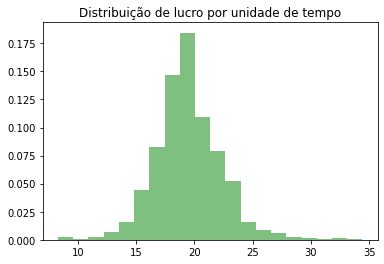


Lucro máximo por unidade de tempo: 24.805248501737893
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 24.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 7

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 30
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.2
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  24.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  50
Custo por unidade 7
Lucro Total: 365.9433146341648 = 34.01%
Lucro por unidade de tempo: 15.247638109756865

Horários de chegada dos clientes: [0.2482104735975356, 0.32516993507708486, 0.35178566415398266, 0.38955169242122134, 0.46831837137078197, 0.5542650786666584, 0.5645318765273932, 0.657031986914139, 0.7372632482533295, 0.7507379410349088, 0.8298205224355358, 0.8415106414287363, 0.8844416893781178, 0.9281535463467039, 1.6594663362425255, 1.6941980927610552, 1.8049732166881574, 1.8056545464352318, 1.8217424186706372, 1.8301879417195117, 1.8552646376930932, 1.9523295346875087, 2.0599471814938206, 2.113193125614328, 2.203293579935078, 2.231456606840605, 2.5741145803206935, 2.593837935901743, 2.602540948498768, 2.7308275378439224, 2.7501501885553608, 2.809193536579876, 2.921960789611944, 3.001211462443093, 3.445968570832578, 4.3344479333659

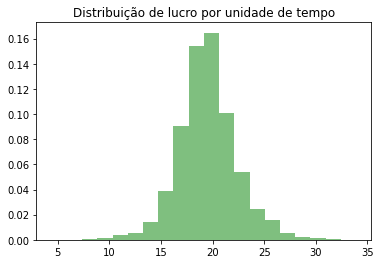


Lucro máximo por unidade de tempo: 24.838021483921306
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 24.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 7

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.1
alpha = 0.05

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  17.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  50
Custo por unidade 7
Lucro Total: 437.88676422058563 = 59.66%
Lucro por unidade de tempo: 25.758044954152098

Horários de chegada dos clientes: [0.35414116019024333, 0.47651735612208945, 0.5367346077943134, 0.6273297655464708, 0.7425911080578471, 0.8028432874618533, 0.9496468658592407, 1.8098378235651218, 1.9385607212271847, 2.1802999912456524, 2.3779751810253504, 2.4751486880751163, 2.4889840627027198, 2.5920263455326267, 2.7125887233123707, 2.7585573825904306, 2.762208789077237, 2.841665838271605, 3.4720335611060666, 3.5520154996466404, 3.828160752697457, 4.2783255447804045, 4.2784826322794, 4.452192599365295, 4.806297639621773, 5.099283297845358, 5.4430182714463955, 5.484114202083708, 5.548659217759784, 5.613800517287159, 5.642103352007228, 5.681400905700752, 5.709164163770521, 5.777378282750586, 5.819436743701265, 5.846948821287652, 5.87

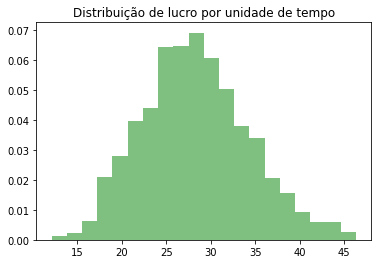


Lucro máximo por unidade de tempo: 32.595629079019844
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 17.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 1 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 7

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.3
alpha = 0.2

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  17.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  40
Custo por unidade 7
Lucro Total: 329.1287810156076 = 53.48%
Lucro por unidade de tempo: 19.36051653032986

Horários de chegada dos clientes: [0.05954426171599046, 0.10252306265741679, 0.22126841323280833, 0.293117328957467, 0.41181288946364025, 0.5794142316323043, 0.59189893755202, 0.7132234169380784, 0.7421828929137226, 0.9000633816214294, 1.0258200654288303, 1.1138097194938583, 1.3743795812026538, 1.7474064499317696, 1.975777014226252, 2.0625791835188174, 2.128257862148795, 2.2030620087443253, 2.583773605659471, 2.682412234437913, 2.778572701314058, 2.8079533250539486, 2.8148593523775345, 2.933959347555297, 2.936094246802011, 2.998342065019381, 3.286936110870197, 4.07210329794328, 4.077675044963719, 4.5382230793029, 4.72888169746945, 4.85447419126195, 4.915213461047695, 4.999796616895282, 5.00906781274828, 5.0374262248580575, 5.0983785730

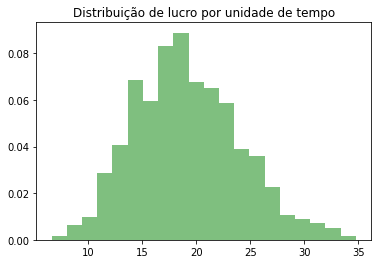


Lucro máximo por unidade de tempo: 22.40788326534138
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 17.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 40 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 1 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 7

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.3
alpha = 0.2

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  17.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  40
Custo por unidade 7
Lucro Total: -1.2142887190099145 = -0.23%
Lucro por unidade de tempo: -0.0714287481770538

Horários de chegada dos clientes: [0.14300272659961796, 0.35083192070777247, 0.3738899384374944, 0.3854280214590454, 0.4574279727083637, 0.48074406872528175, 0.5755330765878307, 0.6846533185336238, 0.8510469639499529, 0.8566965061111461, 0.8578502062896912, 0.8689569940211329, 0.8925658500211734, 0.8964902439302666, 1.0404272760763775, 1.2123796033477983, 1.348483257821445, 1.4980619519428573, 1.5983670251625006, 1.6849189900272337, 1.7335392112351609, 1.7765208940038506, 1.8296113104532863, 1.8320368245719618, 1.8328072198026708, 1.9257961066504898, 2.0991318497147846, 2.1020667375580797, 2.20366105336258, 2.3075432799368523, 2.3287893039215173, 2.575488258455511, 2.6613790565665996, 2.6702498622652415, 2.7182028568501915, 2.73223

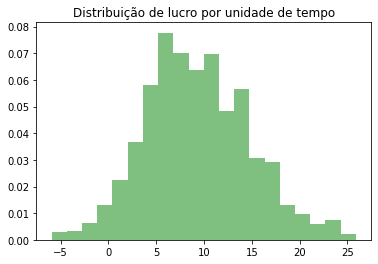


Lucro máximo por unidade de tempo: 14.50625566691688
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 17.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 40 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 7

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.3
alpha = 0.2

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  120.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  50
Custo por unidade 10
Lucro Total: 2518.5978881895207 = 42.2%
Lucro por unidade de tempo: 20.98831573491267

Horários de chegada dos clientes: [0.047097402128118554, 0.07812382247262287, 0.2565546089993066, 0.514393928756647, 0.6136700885891299, 0.7118355792466962, 0.7139835106628177, 0.7987244725576312, 0.9729621965871922, 1.1992080457680803, 1.778551566993629, 1.849982527807041, 2.021616692278878, 2.077523249833918, 2.1572807434507695, 2.268683052992848, 2.281865354627032, 2.321116311282114, 2.3637228370822916, 2.421659946675451, 2.5896908935288514, 2.71990353448081, 2.758883703574145, 2.893672084107099, 2.905032213833579, 2.9126279952699257, 2.923635899800105, 2.9568381128204604, 3.230233837755562, 4.027621255803614, 4.303290173941331, 4.962876407609998, 5.044320297937862, 5.112438018163178, 5.1696365981684265, 5.188357581576265, 5.21169

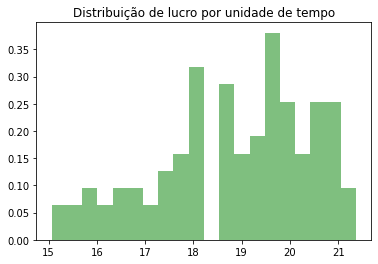


Lucro máximo por unidade de tempo: 23.30794231383704
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 120.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 10

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.3
alpha = 0.2

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  120.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  50
Custo por unidade 10
Lucro Total: 2221.0857293473605 = 39.67%
Lucro por unidade de tempo: 18.509047744561336

Horários de chegada dos clientes: [0.009413451049374123, 0.1664253629704871, 0.23241452220027645, 0.27290416202218487, 0.2880060985622166, 0.4953196341925741, 0.7446088887651167, 0.9436376226163442, 1.0149296157091439, 1.3007416292559433, 1.3873179001783682, 1.7929907109278762, 1.9486744051508544, 1.9859764841279883, 2.0252693309825562, 2.0307099669575592, 2.19415730628392, 2.2712796592467344, 2.2847970136551337, 2.494487875989582, 2.5045016119421697, 2.603310713047176, 2.7438560507285183, 2.837678156781184, 2.8704789344806687, 3.1515112415140245, 3.362804791082388, 4.292627426035603, 4.728248625880813, 5.275689616575987, 5.280376051781182, 5.362432011770902, 5.541619278590666, 5.5800693157257575, 5.6067867023623865, 5.825769617039

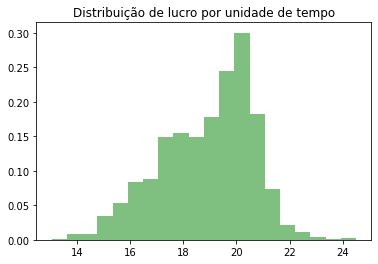


Lucro máximo por unidade de tempo: 23.362480690472566
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 120.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 10

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.1
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  240.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  50
Custo por unidade 10
Lucro Total: 4794.864837821023 = 41.49%
Lucro por unidade de tempo: 19.97860349092093

Horários de chegada dos clientes: [0.1478008398922765, 0.19358001536588748, 0.20143909581313585, 0.3048587470629307, 0.41395469685013825, 0.4773550343838509, 0.5223100496591058, 0.551956367576058, 0.5692105575633252, 0.6557714518814247, 0.6982944592551034, 0.7250192198727574, 0.7495990515595556, 0.862481097725561, 0.9505357432619497, 0.9735260459792787, 1.1611623954606767, 1.555945264980829, 1.681168363842429, 1.8687716363334514, 2.03158258186605, 2.0438236279704216, 2.1852303487324107, 2.339653413391776, 2.428806705815228, 2.4487638161221588, 2.459702796153105, 2.5104103606489505, 2.6325625273090734, 2.7569944663964394, 2.818250168607535, 3.1457784914298363, 3.2866105702734587, 4.128764921301192, 4.312536449538799, 4.314144323342743

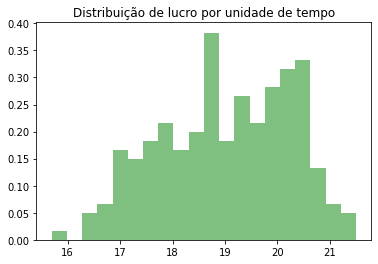


Lucro máximo por unidade de tempo: 23.495720357971017
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 240.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 10

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(T0))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.2
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")

--------------------Parametros utilizados:--------------------
T:  240.0
Max Estoque:  20
Min Estoque:  1
Qtd inicial estoque:  3
Preço da unid:  50
Custo por unidade 7
Lucro Total: 5716.612825451582 = 48.39%
Lucro por unidade de tempo: 23.819220106048256

Horários de chegada dos clientes: 2448

Horário de chegada dos pedidos: [4.314314861472889, 22.523149647170815, 43.06533559872582, 62.727242141653406, 80.42151516294041, 99.51430240519903, 119.62404345559706, 141.1719650099375, 160.06280451318412, 176.57132452195447, 196.9466214108765, 217.60598009640222, 236.44409775549195]



--------------------Parametros utilizados:--------------------
nsamples:  100
--------------------Parametros utilizados:--------------------
Tolerância:  0.1
Alpha:  0.1
Lucro médio por unidade de tempo: 22.086643926957336
1.4920634897183607
Número de cenários necessários: 808
A média está no intervalo [22.015960885594748,22.157326968319925] com a probabilidade de 0.9.





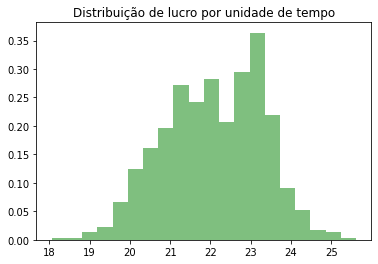


Lucro máximo por unidade de tempo: 26.767705624186164
Melhor política de pedidos (minEstoque, maxEstoque): (5,15)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

from tqdm.notebook import tqdm
# from tqdm import tqdm
# tqdm().pandas()

%matplotlib inline

# Pode variar
T = 240.0
maxEstoque = 20 # máximo disponível
minEstoque = 1 # mínimo disponível
x0 = 3 # quantidade inicial no inventário
precoPorUnidade = 50 # preço por unidade
und = 2 # unidade de tempo antes do pedido chegar
custo = 2 # custo de manutenção do inventário
maxRate = 10 # número máximo de clientes por unidade de tempo
recebeAteFechar = True # pedidos podem chegar depois de fechar
custoAteFechar = True # o custo de manutenção é cobrado até o fechamento da loja
custoPorUnidade = 7

print("--------------------Parametros utilizados:--------------------")
print("T: ",T)
print("Max Estoque: ", maxEstoque)
print("Min Estoque: ", minEstoque)
print("Qtd inicial estoque: ", x0)
print("Preço da unid: ", precoPorUnidade)
print("Custo por unidade", custoPorUnidade)

def cost(x): 
    return x * custoPorUnidade

def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

def proxChegada(t,rate,maxRate):
    while(1):
        Z = exponencial(1,maxRate)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / maxRate:
            return t

def exponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x


def inventario(G,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar):
    
    qtdCusto = 0.0 # valor de custos de pedidos
    qtdReceita = 0.0 # valor da receita obtida
    valCusto = 0.0 # valor total do custo de manutenção
    qtdInventario = x0 # quantidade no inventário
    qtdPedido = 0 # quantidade no pedido
    t = 0.0 
    t0 = proxChegada(t,rate,maxRate) # hora de chegada do próximo cliente
    t1 = 1.0e+30 # tempo de entrega do pedido
    T0 = []
    T1 = []
    
    while(1):
        #cliente chegou depois da entrega
        if t0 < t1 and t0 <= T:
            valCusto = valCusto + (t0 - t) * qtdInventario * custo
            t = t0
            T0.append(t0)
            demanda = G(1,rate(t))[0] # demanda do cliente
            valorPedidoPreenchido = min(demanda,qtdInventario) # valor do pedido que pode ser vendido
            qtdReceita = qtdReceita + valorPedidoPreenchido * precoPorUnidade
            qtdInventario = qtdInventario - valorPedidoPreenchido
            # política de pedidos
            if qtdInventario < minEstoque and qtdPedido == 0:
                qtdPedido = maxEstoque - qtdInventario
                t1 = t + und
            t0 = proxChegada(t,rate,maxRate)
            
        # pedido chega antes do próximo cliente
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            valCusto = valCusto + (t1 - t) * custo * custo # Porque aqui é custo * custo?
            t = t1
            T1.append(t1)
            qtdCusto = qtdCusto + cost(qtdPedido)
            qtdInventario = qtdInventario + qtdPedido
            qtdPedido = 0
            t1 = 1.0e+30
            
        else:
            # loja é fechada e ainda existe um pedido pendente
            if qtdPedido > 0 and recebeAteFechar:
                valCusto = valCusto + (t1 - t) * qtdInventario * custo
                t = t1
                T1.append(t1)
                qtdCusto = qtdCusto + cost(qtdPedido)
                qtdInventario = qtdInventario + qtdPedido
                qtdPedido = 0
                
            elif custoAteFechar:
                valCusto = valCusto + (T - t) * qtdInventario * custo
                
            lucroTotal = qtdReceita - qtdCusto - valCusto
            lucroPorUnidade = lucroTotal / T # Lucro por unidade de tempo
            return qtdReceita, lucroTotal, lucroPorUnidade, T0, T1


qtdReceita, lucroTotal, lucroPorUnidade, T0, T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
print("Lucro Total: " + str(lucroTotal) + " = "+str(round(lucroTotal/qtdReceita*100, 2))+"%")
print("Lucro por unidade de tempo: " + str(lucroPorUnidade))
print()
print("Horários de chegada dos clientes: " + str(len(T0)))
print()
print("Horário de chegada dos pedidos: " + str(T1))
print("\n\n")

nsamples = 100
print("--------------------Parametros utilizados:--------------------")
print("nsamples: ", nsamples)

def toleranciaDoInventario(tol,alpha):
#     nsamples = 30
    x = np.zeros(nsamples)
    for i in range(nsamples):
        qtdReceita, lucroTotal,lucroPorUnidade,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        x[i] = lucroPorUnidade
    n  = nsamples
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        qtdReceita, lucroTotal,nx,T0,T1 = inventario(exponencial,T,maxEstoque,minEstoque,cost,x0,precoPorUnidade,und,custo,rate,maxRate,recebeAteFechar,custoAteFechar)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

# Pode variar
tol = 0.1
alpha = 0.1

print("--------------------Parametros utilizados:--------------------")
print("Tolerância: ", tol)
print("Alpha: ", alpha)

m,s2,n,x = toleranciaDoInventario(tol,alpha)
print("Lucro médio por unidade de tempo: " + str(m))
print(s2)
print("Número de cenários necessários: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("A média está no intervalo [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] com a probabilidade de " + str(1.0 - alpha) + ".")
print("\n\n")


plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Distribuição de lucro por unidade de tempo")
plt.show()

lucro_maximo = -1.0e+30
best_maxEstoque = 0
best_minEstoque = 0

# f1 = FloatProgress(min=0, max=11)
# f2 = FloatProgress(min=0, max=11)
# display(f1)
# display(f2)

# rMaxEstoque = range(15,26)
# rMinEstoque = (15,4,-1)

# with tqdm(total=len(rMaxEstoque)) as pbar:
for maxEstoque in tqdm(range(15,26)):
# for maxEstoque in range(15,26):
#     for minEstoque in tqdm(range(15,4,-1)):
    for minEstoque in range(15,4,-1):
        m,s2,n,x = toleranciaDoInventario(tol,alpha)
        if m > lucro_maximo:
            lucro_maximo = m
            best_maxEstoque = maxEstoque
            best_minEstoque = minEstoque
#         f2.value = f2.value + 1
#     f1.value = f1.value + 1
            
print("Lucro máximo por unidade de tempo: " + str(lucro_maximo))
print("Melhor política de pedidos (minEstoque, maxEstoque): (" + str(best_minEstoque) + "," + str(best_maxEstoque) + ")")